# Conditional Varional Autoencoder for resonator design

This notebook demonstrates how to train conditional Variational autoencoder (cVAE) to get a model, which proposes different parameteric designs with user specified resonating properties.

The structure is a follows.

1. Training the cVAE on some data
2. Checking consistency of the cVAE
3. Making predictions for new designs.

That should allow the user to understand the basic usage of the cVAE code.


# Train or load the cVAE

In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append('../')
sys.path.append('../daaad/')
sys.path.append('../daaad/src')

from daaad.src.models.cae import CondVAEModel
from daaad.src.dataset.data_set import DataSet
from src import data_io, cvae_utils
import numpy as np
from data_io import get_spiral_data

np.random.seed(42)
# Number of spectral modes to be used
num_modes = 2
# Name of the model
model_name = f'spiral_{num_modes}modes'
# Fraction of data to be used (between 0 and 1)
data_fraction = 1.
# Whether only frequencies or also modal masses should be considered
only_freqs = False
# Training end testing parameters
batch_size = 128
val_split = .1
test_split  = .1
# This is just a correction factor provided by Sander, due to different material used in the end for the experiment
# If not needed, just delete it's usage or set it to 1.
correction_factors={'modal_mass': 0.1258,'freqs': 0.2858}
# This function needs to be implemented for a new dataset
dataset, apply_log = get_spiral_data(num_modes=num_modes, data_fraction=data_fraction, only_freqs=only_freqs)
# Creates dataloaders for training, validation and testing
train_gen, val_gen, test_gen = dataset.get_data_loaders(batch_size, val_split=val_split, test_split=test_split)

# Loads a trained model, if exists, otherwise trains a new one
try:
    model = CondVAEModel.load_model(f'../saved_models/{model_name}/')
except:
    os.mkdir(f'../saved_models/{model_name}/')
    # To change the architecture of the VAE check the documentation of this functions.
    # Newly trained model is saved. If you want to retrain the model with the same name, the file must be deleted.
    model = cvae_utils.train_cvae(model_name, dataset, train_gen, val_gen)


/home/christian/miniconda3/envs/resonator_design/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Plot the design errors of the cVAE

To check for consistency we ask the cVAE to propose some designs for resonant properties, and then compare the predicted resonant properties for the proposed designs to the actual ones. i.e. $\text{design error} = |\text{predicited resonance feature}-\text{requested resonant feature}|$.

(1043, 1, 1000)


/home/christian/miniconda3/envs/resonator_design/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/christian/miniconda3/envs/resonator_design/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/christian/miniconda3/envs/resonator_design/lib/python3.10/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/christian/miniconda3/envs/resonator_design/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/christian/miniconda3/envs/resonator_design/lib/python3.10/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered 

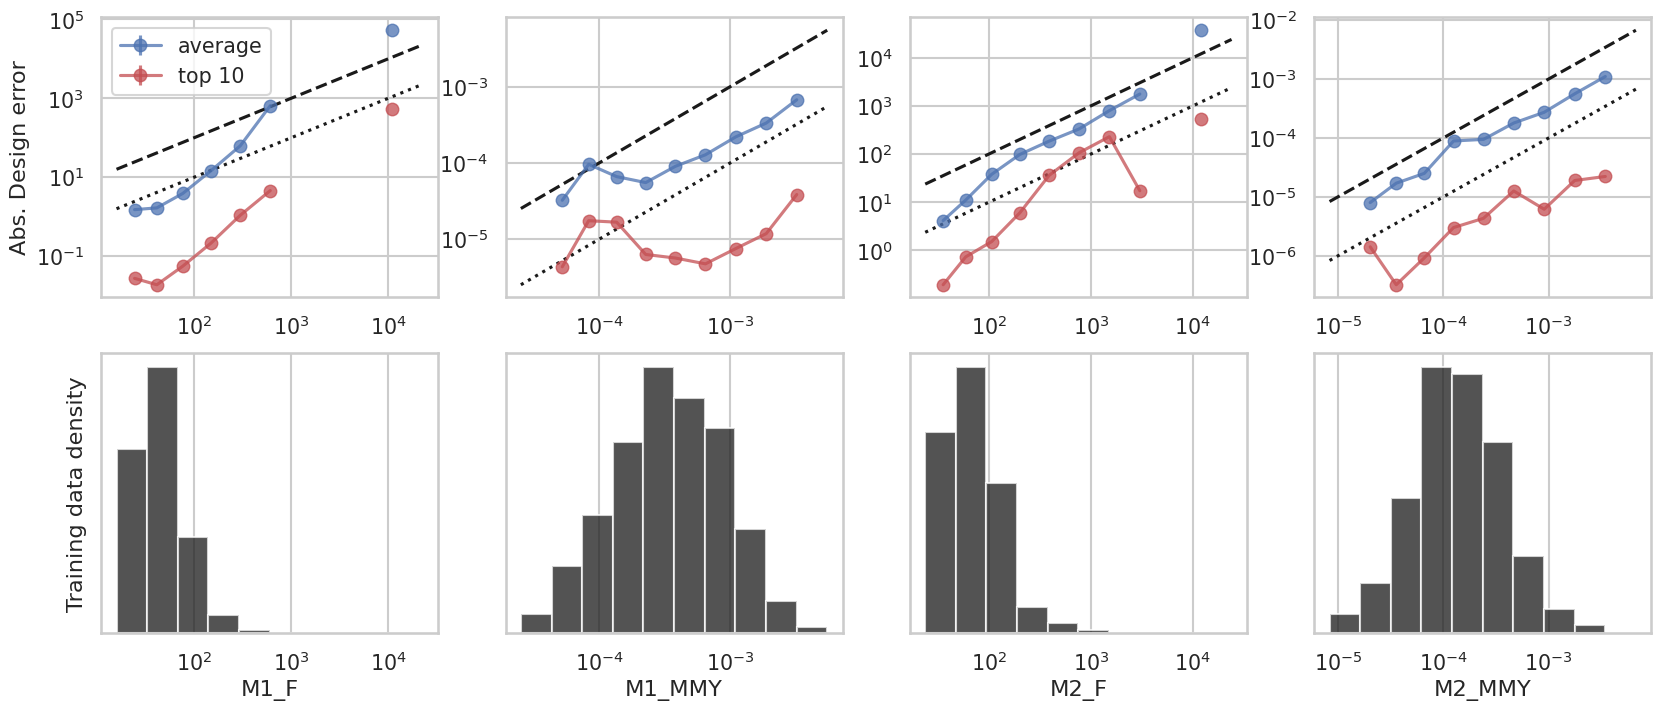

In [2]:
fig, ax1_list, ax2_list = cvae_utils.plot_design_errors(model=model, data_gen=test_gen, 
                                                        linear=True, correction_factors=correction_factors) 

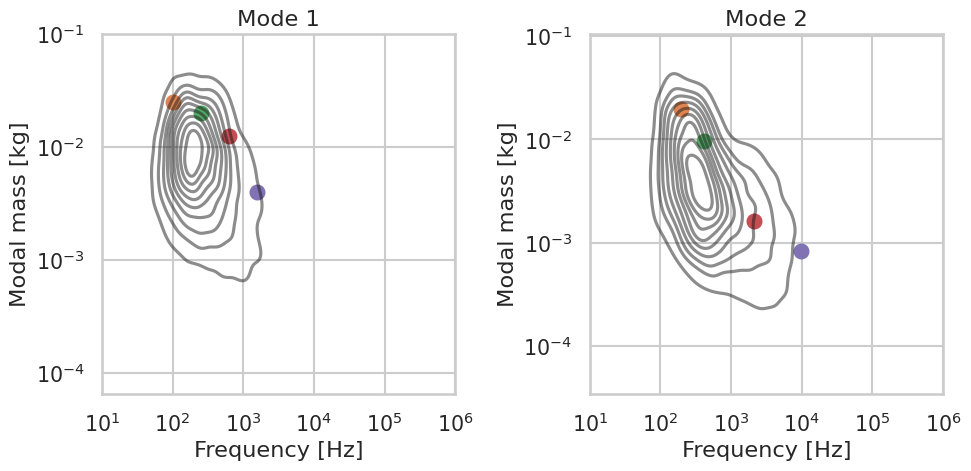

In [93]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
num_designs_to_save = 20
# Requests were generated by looking at the training data and choosing some "covered area".
request_points = np.array([[ 2.        , -1.6       ,  2.28948824, -1.70972499],
                            [ 2.4       , -1.7       ,  2.61539854, -2.01355616],
                            [ 2.8       , -1.9       ,  3.33075148, -2.7877342 ],
                            [ 3.2       , -2.4       ,  3.98432317, -3.07735873]])

plt.figure(figsize=(5 * num_modes,5))
for imodes in range(num_modes):
    ax = plt.subplot(1,num_modes,imodes+1)
    sn.kdeplot(x=train_gen.dataset.dataset.y[f'log_M{imodes+1}_F'].data[:,0], y=train_gen.dataset.dataset.y[f'log_M{imodes+1}_MMY'].data[:,0],ax=ax,color='k', alpha=0.5)
    for idesign in range(request_points.shape[0]):
        ax.scatter(request_points[idesign,0+2*imodes], request_points[idesign,1+2*imodes], color=f'C{idesign+1}', s=100)
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('Modal mass [kg]')
    ax.set_title(f'Mode {imodes+1}')
    xticks = ax.get_xticks()
    xticks = xticks[xticks % 1 == 0]
    xticklabels = ['$10^{%d}$' %x for x in xticks] 
    ax.set_xticks(xticks, xticklabels)
    yticks = ax.get_yticks()
    yticks = yticks[yticks % 1 == 0]
    yticklabels = ['$10^{%d}$' %y for y in yticks] 
    ax.set_yticks(yticks, yticklabels)
plt.tight_layout()

In [ ]:
# Transforms the requested points into a dictionary that can be used by the model
requested_points = pd.DataFrame(request_points, columns=["log_M1_F", "log_M1_MMY", "log_M2_F", "log_M2_MMY"])
design_dict = requested_points.to_dict(orient='list')
for k,v in design_dict.items():
    design_dict[k] = np.array([v]).T
# Proposes designs based on the requested points
suggested_designs = cvae_utils.propose_design(model=model, design_dict=design_dict, apply_log=apply_log, correction_factors=correction_factors)

 Next we plot the suggested parameters of the design.

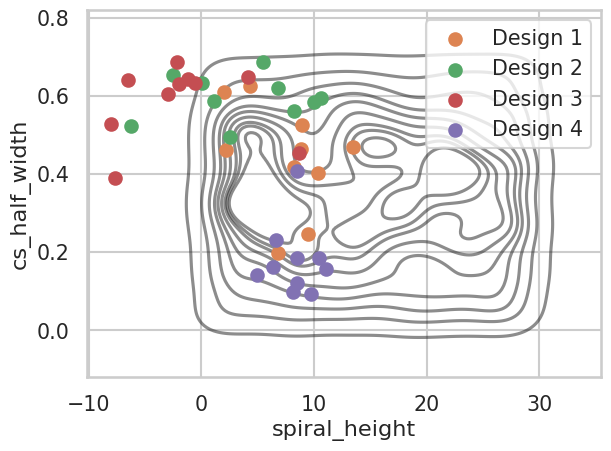

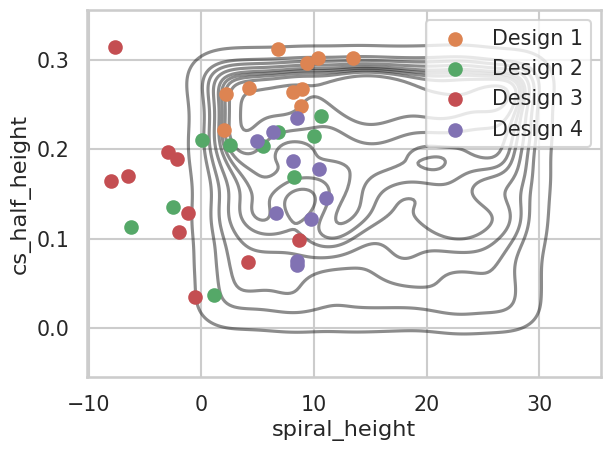

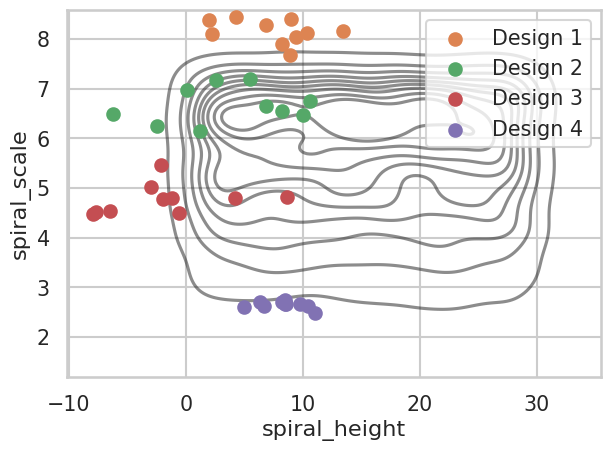

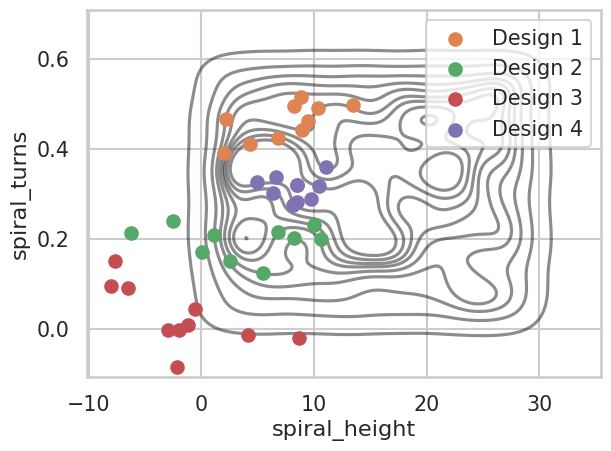

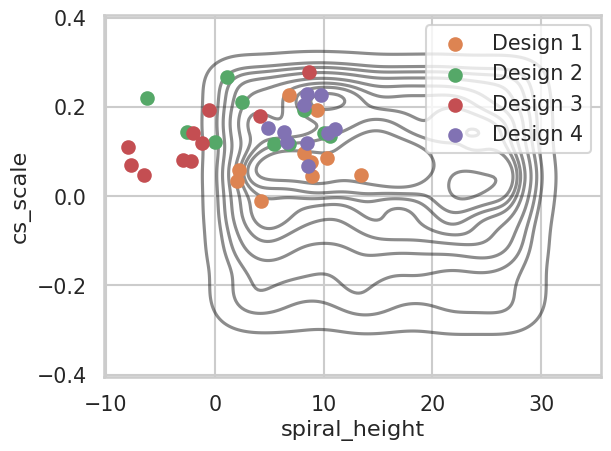

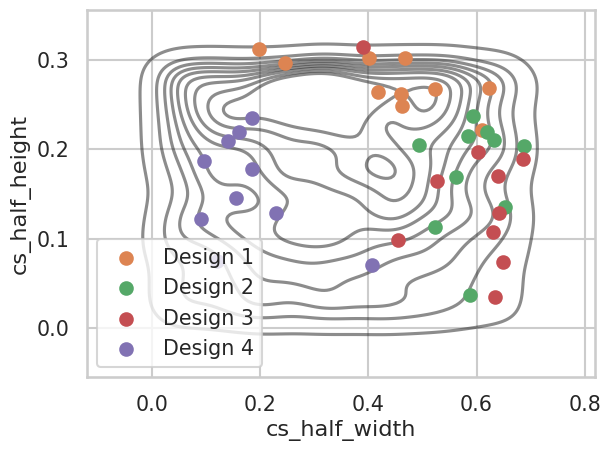

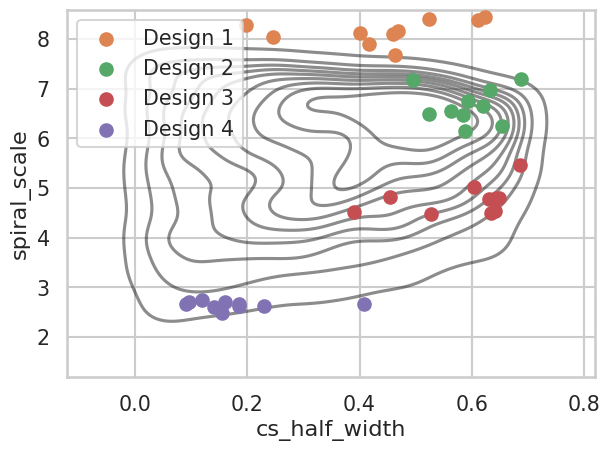

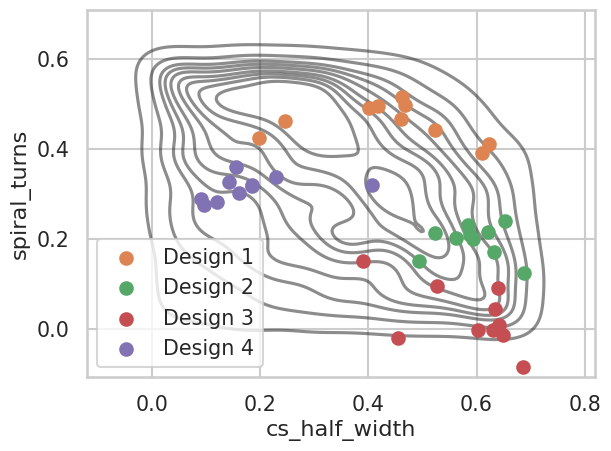

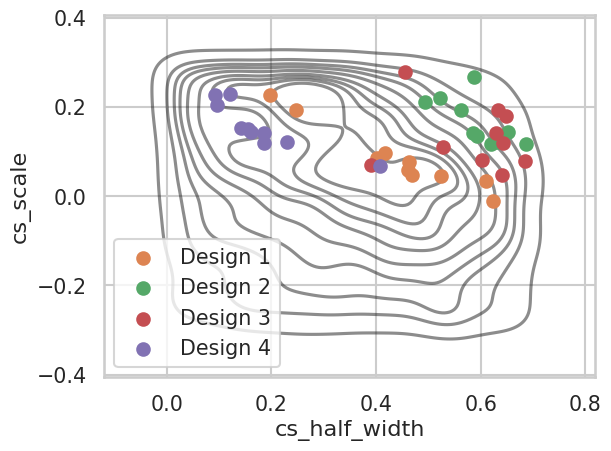

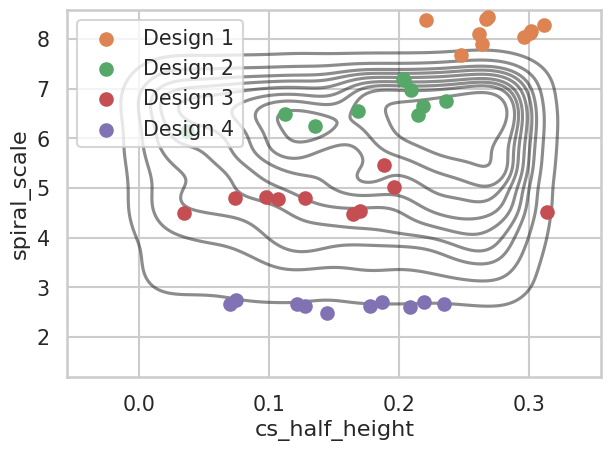

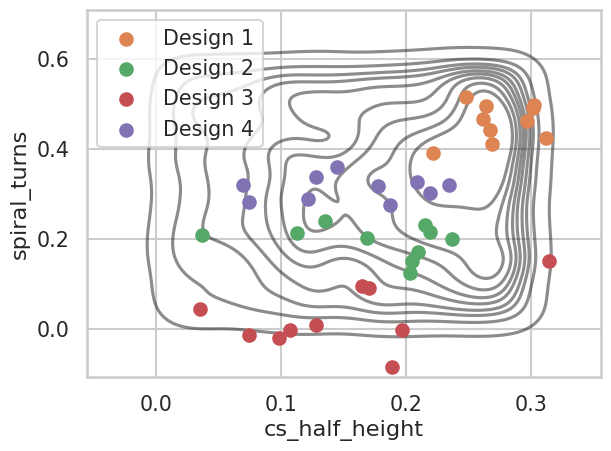

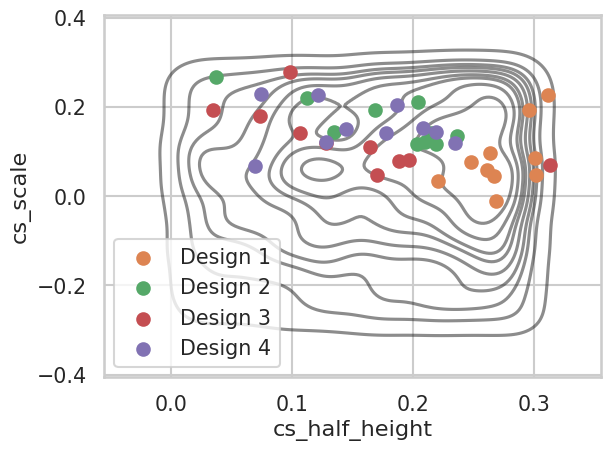

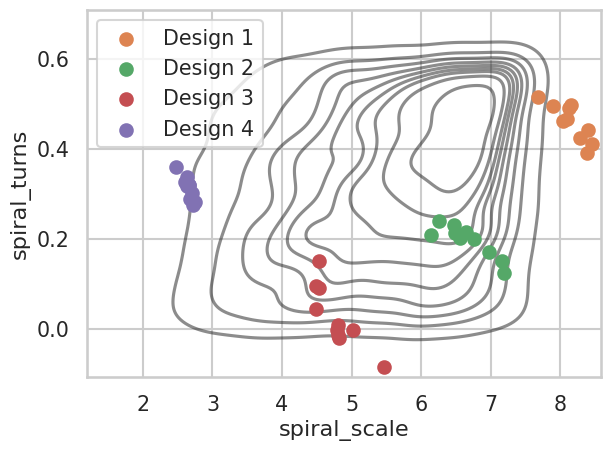

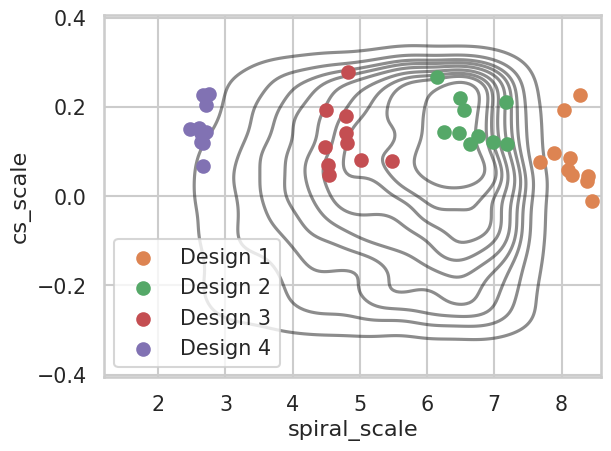

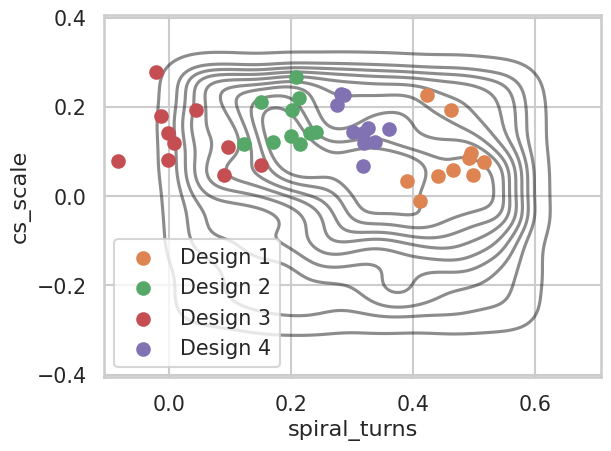

In [63]:
cvae_utils.plot_proposed_designs(model, train_gen, suggested_designs, apply_log=apply_log)

# How to use another dataset

The usage should be quite straight forward, just that the equivalent of `get_spiral_data` in `data_io.py` should be implemented for the new dataset. Check the documentation therein.